# Lecture : Graph Transformers & Graph ViT

## Lab 03 : Graph Transformers with edge features and DGL (sparse linear algebra)

### Xavier Bresson

Dwivedi, Bresson, A generalization of transformer networks to graphs, 2020   
https://arxiv.org/pdf/2012.09699.pdf


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/10_Graph_Transformers'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL
    

In [2]:
# Libraries
import pickle
import dgl
import dgl.function as fn
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time
import networkx as nx
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_ncut
from lib.molecules import Dictionary, MoleculeDataset, MoleculeDGL, Molecule
import os, datetime


# Load molecular datasets

In [3]:
# Select dataset
dataset_name = 'QM9_1.4k'; data_folder_pytorch = 'dataset/QM9_1.4k_pytorch/'; data_folder_dgl = 'dataset/QM9_1.4k_dgl/'

# Load the number of atom and bond types 
with open(data_folder_pytorch + "atom_dict.pkl" ,"rb") as f: num_atom_type = len(pickle.load(f))
with open(data_folder_pytorch + "bond_dict.pkl" ,"rb") as f: num_bond_type = len(pickle.load(f))
print(num_atom_type)
print(num_bond_type)

# Load the DGL datasets
datasets_dgl = MoleculeDataset(dataset_name, data_folder_dgl)
trainset, valset, testset = datasets_dgl.train, datasets_dgl.val, datasets_dgl.test
print(len(trainset))
print(len(valset))
print(len(testset))
idx = 0
print(trainset[:2])
print(valset[idx])
print(testset[idx])


9
4
Loading datasets QM9_1.4k_dgl...
train, test, val sizes : 1000 200 200
Time: 0.5021s
1000
200
200
([Graph(num_nodes=9, num_edges=20,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), Graph(num_nodes=9, num_edges=18,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)})], [tensor([-0.2532]), tensor([1.0897])])
(Graph(num_nodes=9, num_edges=18,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([0.5060]))
(Graph(num_nodes=9, num_edges=20,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([-4.4048]))


# Add positional encoding feature

In [4]:
# Positional encoding as Laplacian eigenvectors
def LapEig_positional_encoding(g, pos_enc_dim):
    Adj = g.adj().to_dense() # Adjacency matrix
    Dn = ( g.in_degrees()** -0.5 ).diag() # Inverse and sqrt of degree matrix
    Lap = torch.eye(g.number_of_nodes()) - Dn.matmul(Adj).matmul(Dn) # Laplacian operator
    EigVal, EigVec = torch.linalg.eig(Lap) # Compute full EVD
    EigVal, EigVec = EigVal.real, EigVec.real # make eig real
    EigVec = EigVec[:, EigVal.argsort()] # sort in increasing order of eigenvalues
    EigVec = EigVec[:,1:pos_enc_dim+1] # select the first non-trivial "pos_enc_dim" eigenvector
    return EigVec

# Add node and edge features to graphs
pos_enc_dim = 3 # dimension of PE, QM9
def add_node_edge_features(dataset):
    for (graph,_) in dataset:
        graph.ndata['pos_enc'] = LapEig_positional_encoding(graph, pos_enc_dim) # node positional encoding feature 
    return dataset

# Generate graph datasets
trainset = add_node_edge_features(trainset)
testset = add_node_edge_features(testset)
valset = add_node_edge_features(valset)
print(trainset[0])


(Graph(num_nodes=9, num_edges=20,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64), 'pos_enc': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([-0.2532]))


# Visualize positional encoding

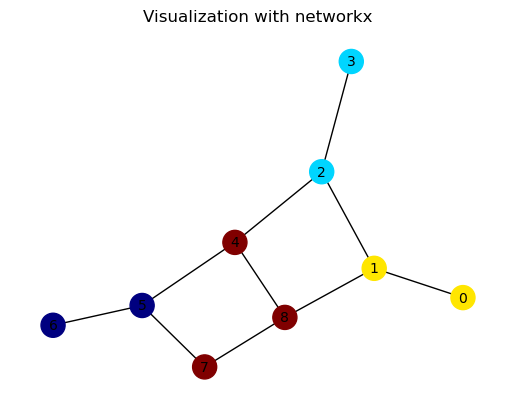

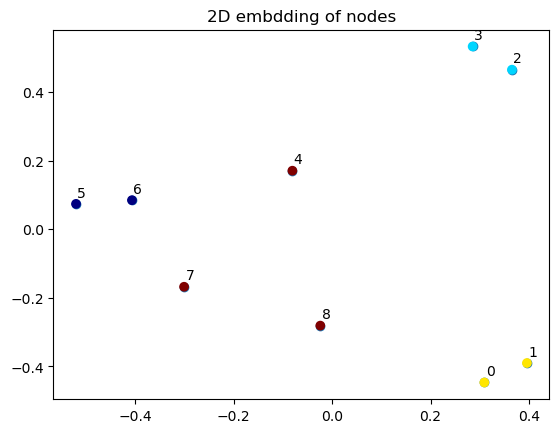

In [5]:
graph = trainset[0][0]

# Visualize graph
fig = plt.figure()
ax = fig.add_subplot(111)
Adj = graph.adj().to_dense()
A_nx = nx.from_numpy_array(Adj.numpy())
C = compute_ncut(Adj.long(), 4)
nx.draw(A_nx, ax=ax, node_color=C, cmap='jet', with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Visualization with networkx')
plt.show()

# plot 2D coordinates
fig = plt.figure()
ax = fig.add_subplot(111)
x = graph.ndata['pos_enc']
ax.scatter(x[:,0], x[:,1])
idx = list(range(graph.number_of_nodes()))
ax.scatter(x[:,0], x[:,1], c=C, cmap='jet')
for i, txt in enumerate(idx):
    ax.annotate(txt, (x[:,0][i], x[:,1][i]), textcoords="offset points", xytext=(1,5))
ax.title.set_text('2D embdding of nodes')
plt.show()


# Define the collate function to prepare a batch of DGL graphs and test it

In [6]:
# collate function prepares a batch of graphs, labels and other graph features (if needed)
def collate(samples):
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples))
    batch_graphs = dgl.batch(graphs)    # batch of graphs
    batch_labels = torch.stack(labels)  # batch of labels (here chemical target)
    return batch_graphs, batch_labels


# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
batch_x = batch_graphs.ndata['feat']
print('batch_x:',batch_x.size())
batch_pe = batch_graphs.ndata['pos_enc']
print('batch_pe:',batch_pe.size())
batch_e = batch_graphs.edata['feat']
print('batch_e:',batch_e.size())


Graph(num_nodes=90, num_edges=192,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64), 'pos_enc': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)})
tensor([[ 3.9472],
        [-4.0181],
        [ 1.9524],
        [-1.5489],
        [ 0.5479],
        [-1.0082],
        [ 3.5653],
        [-1.1304],
        [ 2.6200],
        [-7.4328]])
batch_x: torch.Size([90])
batch_pe: torch.Size([90, 3])
batch_e: torch.Size([192])


# Design the class of GraphTransformer networks with edge features 

Node update equation:  
\begin{eqnarray*}
\bar{h}^{\ell} &=&  h^{\ell} + \textrm{gMHA} (\textrm{LN}(h^{\ell}),\textrm{LN}(e^{\ell})) \in \mathbb{R}^{N\times d}\\
h^{\ell+1} &=& \bar{h}^{\ell} + \textrm{MLP} (\textrm{LN}(\bar{h}^{\ell}))  \in \mathbb{R}^{N\times d}\\
&&\textrm{with } \textrm{gMHA}(h,e)=\textrm{Concat}_{k=1}^H \left( \textrm{gHA}(h_k,e_k) \right) W_O \in \mathbb{R}^{N\times d},\ h_k\in \mathbb{R}^{N\times d'=d/H}, e_k\in \mathbb{R}^{E\times d'}, W_O\in \mathbb{R}^{d\times d} \\
&&\quad\quad\ \textrm{gHA}(h,e)_i= \sum_{j\in \mathcal{N}_i} \underbrace{\frac{\exp(q_i^T \textrm{diag}(e_{ij}) k_j/\sqrt{d'})}{ \sum_{j'\in\mathcal{N}_i} \exp(q_i^T \textrm{diag}(e_{ij'}) k_{j'}/\sqrt{d'}) }}_{\textrm{graph attention score w/ edge feature}_{ij}} v_j\ \textrm{ (point-wise equation)}\\
&&\quad\quad\ Q=h_k W_Q, K=h_k W_K, V=h_k W_V\in \mathbb{R}^{N\times d'=d/H}, E=e_k W_E\in \mathbb{R}^{E\times d'=d/H}, W_Q, W_K, W_V, W_E\in \mathbb{R}^{d'\times d'}\\
h^{\ell=0} &=& \textrm{LL}_1(h_0)+\textrm{LL}_2(p_0) \in \mathbb{R}^{N\times d}\ \textrm{(input node feature and positional encoding)}\\
&&\textrm{with } p_0=\Phi_{\{2,..,K+1\}}\in \mathbb{R}^{N\times K},\ \Delta = \Phi \Lambda \Phi^T \in \mathbb{R}^{N\times N}
\end{eqnarray*}

Edge update equation:  
\begin{eqnarray*}
\bar{e}^{\ell} &=&  e^{\ell} + \textrm{gMHE} (\textrm{LN}(e^{\ell}),\textrm{LN}(h^{\ell}))  \in \mathbb{R}^{E\times d}\\
e^{\ell+1} &=& \bar{e}^{\ell} + \textrm{MLP} (\textrm{LN}(\bar{e}^{\ell})) \in \mathbb{R}^{E\times d}\\
&&\textrm{with } \textrm{gMHE}(e,h)=\textrm{Concat}_{k=1}^H \left( \textrm{gHE}(e_k,h_k) \right) W_O^e \in \mathbb{R}^{E\times d},\ h_k\in \mathbb{R}^{N\times d'=d/H}, e_k\in \mathbb{R}^{E\times d'}, W_O^e\in \mathbb{R}^{d\times d} \\
&&\textrm{with } \textrm{gHE}(e,h)_{ij}=q_i \odot e_{ij} \odot k_j/\sqrt{d'} \in \mathbb{R}^{d'} \textrm{ (point-wise equation)}\\
e^{\ell=0} &=& \textrm{LL}(e_0) \in \mathbb{R}^{E\times d}\ \textrm{(input edge feature)}\\
\end{eqnarray*}


In [7]:
# class graph multi head attention layer  
class graph_MHA_layer(nn.Module): # MHA = Multi Head Attention
    
    def __init__(self, hidden_dim, head_hidden_dim, num_heads): # hidden_dim = d
        super().__init__()
        self.head_hidden_dim = head_hidden_dim # head_hidden_dim = d' = d/K
        self.num_heads = num_heads # number of heads = K
        self.WQ = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True) # define K x W matrix of size=(d',d')
        self.WK = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WV = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WE = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WF = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WG = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        
    # Step 1 of message-passing with DGL: 
    #   Node feature and edge features are passed along edges (src/j => dst/i) 
    def message_func(self, edges): 
        # Compute bi-linear products with edge feature : q_i^T * diag(e_ij) * k_j 
        # You may use "edges.dst[] for i, edges.src[] for j, edges.data[] form ij" 
        qikj = (edges.src['K'] * edges.data['E'] * edges.dst['Q']).sum(dim=2).unsqueeze(2) # size=(E,K,1), edges.src/dst/data[].size=(E,K,d')
        #qikj = ### YOUR CODE HERE, size=(E,K,1), edges.src/dst/data[].size=(E,K,d')
        #qikj = (edges.src['K'] * edges.dst['Q']).sum(dim=2).unsqueeze(2) # NO edge feature
        #qikj = ### YOUR CODE HERE, NO edge feature
        expij = torch.exp( qikj / torch.sqrt(torch.tensor(self.head_hidden_dim)) ) # exp_ij = exp( q_i^T * k_j / sqrt(d') ), size=(E,K,1)
        vj = edges.src['V'] # size=(E,K,d')
        # Compute edge feature : q_i^T * diag(e_ij) * k_j
        eij = edges.src['K'] * edges.data['E'] * edges.dst['Q'] / torch.sqrt(torch.tensor(self.head_hidden_dim)) # e_ij = q_i^T * diag(E_ij) * k_j / sqrt(d'), size=(E,K,d')
        #eij = ### YOUR CODE HERE, size=(E,K,d')
        edges.data['e'] = eij # update edge feature 
        return {'expij' : expij, 'vj' : vj} 
    
    # Step 2 of message-passing with DGL: 
    #   Reduce function collects all messages={hj, eij} sent to node dst/i with Step 1
    #                   and sum/mean over the graph neigbors j in Ni
    def reduce_func(self, nodes):
        expij = nodes.mailbox['expij'] # size=(N,|Nj|,K,1), |Nj|=num_neighbors
        vj = nodes.mailbox['vj'] # size=(N,|Nj|,K,d')
        numerator = torch.sum( expij * vj, dim=1 ) # sum_j exp_ij . v_j, size=(N,K,d')
        denominator = torch.sum( expij, dim=1 ) # sum_j' exp_ij', size=(N,K,1)
        h = numerator / denominator # h_i = sum_j score_ij . v_j , where score_ij = exp_ij / sum_j' exp_ij', size=(N,K,d')
        return {'h' : h} 
    
    def forward(self, g, h, e):
        Q = self.WQ(h) # size=(N, d)
                       # computational trick to compute quickly K linear transformations h_k.WQ of size=(N, d')
                       # first compute linear transformation h.WQ of size=(N, d)
                       # then reshape h.WQ of size=(N, K, d'=d/K)
        K = self.WK(h) # size=(N, d)
        V = self.WV(h) # size=(N, d)
        E = self.WE(e) # size=(E, d)
        F = self.WF(h) # size=(N, d)
        G = self.WG(h) # size=(N, d)
        g.ndata['Q'] = Q.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['K'] = K.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['V'] = V.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.edata['E'] = E.view(-1, self.num_heads, self.head_hidden_dim) # size=(E, K, d'=d/K)
        g.ndata['F'] = F.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['G'] = G.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.update_all(self.message_func, self.reduce_func) # compute with DGL the graph MHA 
        gMHA = g.ndata['h'] # size=(N, K, d'=d/K)
        gMHE = g.edata['e'] # size=(E, K, d'=d/K)
        return gMHA, gMHE
    
    
# class GraphTransformer layer  
class GraphTransformer_layer(nn.Module):
    
    def __init__(self, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim # hidden_dim = d
        self.num_heads = num_heads # number of heads = K
        self.dropout_h_mha = nn.Dropout(dropout) # dropout value
        self.dropout_h_mlp = nn.Dropout(dropout) # dropout value
        self.dropout_e_mha = nn.Dropout(dropout) # dropout value
        self.dropout_e_mlp = nn.Dropout(dropout) # dropout value
        self.gMHA = graph_MHA_layer(hidden_dim, hidden_dim//num_heads, num_heads) # graph MHA layer
        self.WO = nn.Linear(hidden_dim, hidden_dim) # LL
        self.WOe = nn.Linear(hidden_dim, hidden_dim) # LL
        self.layer_norm1 = nn.LayerNorm(hidden_dim) # layer normalization
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.layer_norm1e = nn.LayerNorm(hidden_dim)
        self.layer_norm2e = nn.LayerNorm(hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim) # LL1 for MLP
        self.linear2 = nn.Linear(hidden_dim, hidden_dim) # LL2 for MLP
        self.linear1e = nn.Linear(hidden_dim, hidden_dim) # LL1 for MLP
        self.linear2e = nn.Linear(hidden_dim, hidden_dim) # LL2 for MLP
        
    def forward(self, g, h, e): 
        
        # Self-attention layer
        h_rc = h # size=(N,d), V=num_nodes, for residual connection
        e_rc = e
        h = self.layer_norm1(h) # layer normalization, size=(N, d)
        e = self.layer_norm1e(e) # layer normalization, size=(N, d)
        h_MHA, e_MHE = self.gMHA(g, h, e) # MHA, size=(N, K, d'=d/K)
        h_MHA = h_MHA.view(-1, self.hidden_dim) # size=(N, d)
        e_MHE = e_MHE.view(-1, self.hidden_dim) # size=(N, d)
        h_MHA = self.dropout_h_mha(h_MHA) # dropout, size=(N, d)
        e_MHE = self.dropout_e_mha(e_MHE) # dropout, size=(N, d)
        h_MHA = self.WO(h_MHA) # LL, size=(N, d)
        e_MHE = self.WOe(e_MHE) # LL, size=(N, d)
        h = h_rc + h_MHA # residual connection, size=(N, d)
        e = e_rc + e_MHE # residual connection, size=(N, d)
        
        # Fully-connected layer
        h_rc = h # for residual connection, size=(N, d)
        e_rc = e # for residual connection, size=(N, d)
        h = self.layer_norm2(h) # layer normalization, size=(N, d)
        e = self.layer_norm2e(e) # layer normalization, size=(N, d)
        h_MLP = self.linear1(h) # LL, size=(H, d)
        e_MLP = self.linear1e(e) # LL, size=(H, d)
        h_MLP = torch.relu(h_MLP) # size=(N, d)
        e_MLP = torch.relu(e_MLP) # size=(N, d)
        h_MLP = self.dropout_h_mlp(h_MLP) # dropout, size=(N, d)
        e_MLP = self.dropout_e_mlp(e_MLP) # dropout, size=(N, d)
        h_MLP = self.linear2(h_MLP) # LL, size=(N, d)
        e_MLP = self.linear2e(e_MLP) # LL, size=(N, d)
        h = h_rc + h_MLP # residual connection, size=(N, d)
        e = e_rc + e_MLP # residual connection, size=(N, d)
        
        return h, e
    
    
# class Graph Transformer network
class GraphTransformer_net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GraphTransformer_net, self).__init__()
        input_dim = net_parameters['input_dim']
        pos_enc_dim = net_parameters['pos_enc_dim']
        hidden_dim = net_parameters['hidden_dim']
        num_heads = net_parameters['num_heads']
        L = net_parameters['L']
        self.embedding_h = nn.Embedding(num_atom_type, hidden_dim)
        self.embedding_e = nn.Embedding(num_bond_type, hidden_dim)
        self.embedding_pe = nn.Linear(pos_enc_dim, hidden_dim)
        self.GraphTransformer_layers = nn.ModuleList([ GraphTransformer_layer(hidden_dim, num_heads) for _ in range(L) ]) 
        self.ln_h_final = nn.LayerNorm(hidden_dim)  
        self.linear_h_final = nn.Linear(hidden_dim, 1, bias=True)
        
    def forward(self, g, h, pe, e):
        
        # input node embedding
        h = self.embedding_h(h) # size=(num_nodes, hidden_dim)
        
        # if PE used
        # h = h + self.embedding_pe(pe) # size=(num_nodes, hidden_dim)
        
        # input edge embedding
        e = self.embedding_e(e) # size=(num_edges, hidden_dim)
        
        # graph convnet layers
        for GT_layer in self.GraphTransformer_layers:
            h, e = GT_layer(g, h, e) # size=(num_nodes, hidden_dim)
        
        # MLP classifier
        g.ndata['h'] = h
        mol_token = dgl.mean_nodes(g,'h') # DGL mean function over the neighbors, size=(num_graphs, hidden_dim)  
        y = self.ln_h_final(mol_token)  
        y = self.linear_h_final(y) # size=(num_graphs, num_classes)    

        return y    
    

# Instantiate one network (testing)
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['pos_enc_dim'] = pos_enc_dim
net_parameters['hidden_dim'] = 128
net_parameters['num_heads'] = 8
net_parameters['L'] = 4
net = GraphTransformer_net(net_parameters)
print(net)

batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
batch_x = batch_graphs.ndata['feat']
batch_pe = batch_graphs.ndata['pos_enc']
batch_e = batch_graphs.edata['feat']
batch_labels = batch_labels
batch_scores = net(batch_graphs, batch_x, batch_pe, batch_e)
print(batch_scores.size())


GraphTransformer_net(
  (embedding_h): Embedding(9, 128)
  (embedding_e): Embedding(4, 128)
  (embedding_pe): Linear(in_features=3, out_features=128, bias=True)
  (GraphTransformer_layers): ModuleList(
    (0-3): 4 x GraphTransformer_layer(
      (dropout_h_mha): Dropout(p=0.0, inplace=False)
      (dropout_h_mlp): Dropout(p=0.0, inplace=False)
      (dropout_e_mha): Dropout(p=0.0, inplace=False)
      (dropout_e_mlp): Dropout(p=0.0, inplace=False)
      (gMHA): graph_MHA_layer(
        (WQ): Linear(in_features=128, out_features=128, bias=True)
        (WK): Linear(in_features=128, out_features=128, bias=True)
        (WV): Linear(in_features=128, out_features=128, bias=True)
        (WE): Linear(in_features=128, out_features=128, bias=True)
        (WF): Linear(in_features=128, out_features=128, bias=True)
        (WG): Linear(in_features=128, out_features=128, bias=True)
      )
      (WO): Linear(in_features=128, out_features=128, bias=True)
      (WOe): Linear(in_features=128, out_

/Users/xbresson/miniconda3/envs/gnn_course/lib/python3.8/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


# Train the network

In [8]:
def run_one_epoch(net, data_loader, train=True, loss_fc=None, optimizer=None):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    nb_data = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        bs2 = batch_labels.size(0)
        batch_pe = batch_graphs.ndata['pos_enc']
        batch_pe = batch_pe * ( 2 * torch.randint(low=0, high=2, size=(1,pos_enc_dim)).float() - 1.0 ) # randomly flip sign of eigenvectors
        batch_e = batch_graphs.edata['feat']
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x, batch_pe, batch_e)
        lossMAE = loss_fc(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            lossMAE.backward()
            optimizer.step()
        epoch_loss += bs2 * lossMAE.detach().item()
        nb_data += bs2
    epoch_loss /= nb_data
    return epoch_loss, optimizer


# dataset loaders
batch_size = 50
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['pos_enc_dim'] = pos_enc_dim
net_parameters['hidden_dim'] = 128
net_parameters['num_heads'] = 8
net_parameters['L'] = 4
del net
net = GraphTransformer_net(net_parameters)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)

# loss, optimizer
lossMAE = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
start = time.time()
for epoch in range(100):
    epoch_train_loss, optimizer = run_one_epoch(net, train_loader, True, lossMAE, optimizer)
    with torch.no_grad(): 
        epoch_test_loss = run_one_epoch(net, test_loader, False, lossMAE)[0]
        # epoch_val_loss = run_one_epoch(net, val_loader, False, lossMAE)[0]
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss))
    

Number of parameters: 799233 (0.80 million)
Epoch 0, time 3.4870, train_loss: 1.3605, test_loss: 1.2832
Epoch 1, time 6.6361, train_loss: 1.1895, test_loss: 1.0722
Epoch 2, time 8.8625, train_loss: 1.0280, test_loss: 0.9831
Epoch 3, time 11.1587, train_loss: 1.0266, test_loss: 0.9721
Epoch 4, time 15.6749, train_loss: 0.9678, test_loss: 0.9966
Epoch 5, time 18.2747, train_loss: 0.9638, test_loss: 0.9225
Epoch 6, time 21.0403, train_loss: 0.9349, test_loss: 0.9462
Epoch 7, time 23.7075, train_loss: 0.9111, test_loss: 0.8912
Epoch 8, time 29.4418, train_loss: 0.9031, test_loss: 0.9032
Epoch 9, time 37.6699, train_loss: 0.8862, test_loss: 0.9204
Epoch 10, time 43.6222, train_loss: 0.9059, test_loss: 0.8840
Epoch 11, time 47.5393, train_loss: 0.8541, test_loss: 0.8649
Epoch 12, time 51.4519, train_loss: 0.8321, test_loss: 0.8568
Epoch 13, time 54.2070, train_loss: 0.8430, test_loss: 0.8646
Epoch 14, time 58.3196, train_loss: 0.8201, test_loss: 0.8110
Epoch 15, time 64.0831, train_loss: 0.8

# GT without edge features 

Node update equation: 
\begin{eqnarray*}
\bar{h}^{\ell} &=&  h^{\ell} + \textrm{gMHA} (\textrm{LN}(h^{\ell})) \in \mathbb{R}^{N\times d}\\
h^{\ell+1} &=& \bar{h}^{\ell} + \textrm{MLP} (\textrm{LN}(\bar{h}^{\ell})) \in \mathbb{R}^{N\times d}\\
&&\textrm{with } \textrm{gMHA}(h)=\textrm{Concat}_{k=1}^H \left( \textrm{gHA}(h_k) \right) W_O \in \mathbb{R}^{N\times d},\ h_k\in \mathbb{R}^{N\times d'=d/H}, W_O\in \mathbb{R}^{d\times d} \\
&&\quad\quad\ \textrm{gHA}(h)=\textrm{Softmax}\left( A_G \odot \frac{QK^T}{\sqrt{d'}} \right) V \in \mathbb{R}^{N\times d'=d/H}, A_G\in \mathbb{R}^{N\times N} \textrm{ (graph adjacency matrix)}\\
&&\quad\quad\ \textrm{gHA}(h)_i= \sum_{j\in \mathcal{N}_i} \underbrace{\frac{\exp(q_i^T k_j/\sqrt{d'})}{ \sum_{j'\in\mathcal{N}_i} \exp(q_i^T k_{j'}/\sqrt{d'}) }}_{\textrm{graph attention score}_{ij}} v_j\ \textrm{ (point-wise equation)}\\
&&\quad\quad\ Q=h_k W_Q, K=h_k W_K, V=h_k W_V\in \mathbb{R}^{N\times d'=d/H}, W_Q, W_K, W_V\in \mathbb{R}^{d'\times d'}\\
h^{\ell=0} &=& \textrm{LL}_1(h_0)+\textrm{LL}_2(p_0) \in \mathbb{R}^{N\times d}\ \textrm{(input node feature and positional encoding)}\\
&&\textrm{with } p_0=\Phi_{\{2,..,K+1\}}\in \mathbb{R}^{N\times K},\ \Delta = \Phi \Lambda \Phi^T \in \mathbb{R}^{N\times N}
\end{eqnarray*}


In [9]:
# class graph multi head attention layer  
class graph_MHA_layer(nn.Module): # MHA = Multi Head Attention
    
    def __init__(self, hidden_dim, head_hidden_dim, num_heads): # hidden_dim = d
        super().__init__()
        self.head_hidden_dim = head_hidden_dim # head_hidden_dim = d' = d/K
        self.num_heads = num_heads # number of heads = K
        self.WQ = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True) # define K x WQ matrix of size=(d',d')
        self.WK = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        self.WV = nn.Linear(hidden_dim, head_hidden_dim * num_heads, bias=True)
        
    # Step 1 of message-passing with DGL: 
    #   Node feature and edge features are passed along edges (src/j => dst/i) 
    def message_func(self, edges): 
        # Compute the dot products q_i^T * k_j 
        # You may use "edges.dst[] for i, edges.src[] for j" 
        qikj = (edges.dst['Q'] * edges.src['K']).sum(dim=2).unsqueeze(2) # all dot products q_i^T * k_j, size=(E,K,1), edges.src/dst[].size=(E,K,d')
        #qikj = ### YOUR CODE HERE, size=(E,K,1), , edges.src/dst[].size=(E,K,d')
        expij = torch.exp( qikj / torch.sqrt(torch.tensor(self.head_hidden_dim)) ) # exp_ij = exp( clamp(q_i^T * k_j / sqrt(d')) ), size=(E,K,1)
        vj = edges.src['V'] # size=(E,K,d')
        return {'expij' : expij, 'vj' : vj} 
    
    # Step 2 of message-passing with DGL: 
    #   Reduce function collects all messages={hj, eij} sent to node dst/i with Step 1
    #                   and sum/mean over the graph neigbors j in Ni
    def reduce_func(self, nodes):
        expij = nodes.mailbox['expij'] # size=(N,|Nj|,K,1), |Nj|=num_neighbors
        vj = nodes.mailbox['vj'] # size=(N,|Nj|,K,d')
        # Compute h_i = sum_j score_ij . v_j , where score_ij = exp_ij / sum_j' exp_ij'
        #numerator = ### YOUR CODE HERE, sum_j exp_ij . v_j, size=(N,K,d')
        #denominator = ### YOUR CODE HERE, sum_j' exp_ij', size=(N,K,1)
        numerator = torch.sum( expij * vj, dim=1 ) # sum_j exp_ij . v_j, size=(N,K,d')
        denominator = torch.sum( expij, dim=1 ) # sum_j' exp_ij', size=(N,K,1)
        h = numerator / denominator # h_i = sum_j score_ij . v_j , where score_ij = exp_ij / sum_j' exp_ij', size=(N,K,d')
        return {'h' : h} 
    
    def forward(self, g, h):
        Q = self.WQ(h) # size=(N, d)
                       # computational trick to compute quickly K linear transformations h_k.WQ of size=(N, d')
                       # first compute linear transformation h.WQ of size=(N, d)
                       # then reshape h.WQ of size=(N, K, d'=d/K)
        K = self.WK(h) # size=(N, d)
        V = self.WV(h) # size=(N, d)
        g.ndata['Q'] = Q.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['K'] = K.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.ndata['V'] = V.view(-1, self.num_heads, self.head_hidden_dim) # size=(N, K, d'=d/K)
        g.update_all(self.message_func, self.reduce_func) # compute with DGL the graph MHA 
        gMHA = g.ndata['h'] # size=(N, K, d'=d/K)
        return gMHA
    
    
# class GraphTransformer layer  
class GraphTransformer_layer(nn.Module):
    
    def __init__(self, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim # hidden_dim = d
        self.num_heads = num_heads # number of heads = K
        self.dropout_mha = nn.Dropout(dropout) # dropout value
        self.dropout_mlp = nn.Dropout(dropout) # dropout value
        self.gMHA = graph_MHA_layer(hidden_dim, hidden_dim//num_heads, num_heads) # graph MHA layer
        self.WO = nn.Linear(hidden_dim, hidden_dim) # LL
        self.layer_norm1 = nn.LayerNorm(hidden_dim) # layer normalization
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim) # LL1 for MLP
        self.linear2 = nn.Linear(hidden_dim, hidden_dim) # LL2 for MLP
        
    def forward(self, g, h): 
        
        # Self-attention layer
        h_rc = h # size=(N,d), V=num_nodes, for residual connection
        h = self.layer_norm1(h) # layer normalization, size=(N, d)
        h_MHA = self.gMHA(g, h) # MHA, size=(N, K, d'=d/K)
        h_MHA = h_MHA.view(-1, self.hidden_dim) # size=(N, d)
        h_MHA = self.dropout_mha(h_MHA) # dropout, size=(N, d)
        h_MHA = self.WO(h_MHA) # LL, size=(N, d)
        h = h_rc + h_MHA # residual connection, size=(N, d)
        
        # Fully-connected layer
        h_rc = h # for residual connection, size=(N, d)
        h = self.layer_norm2(h) # layer normalization, size=(N, d)
        h_MLP = self.linear1(h) # LL, size=(H, d)
        h_MLP = torch.relu(h_MLP) # size=(N, d)
        h_MLP = self.dropout_mlp(h_MLP) # dropout, size=(N, d)
        h_MLP = self.linear2(h_MLP) # LL, size=(N, d)
        h = h_rc + h_MLP # residual connection, size=(N, d)
        
        return h
    
    
# class Graph Transformer network
class GraphTransformer_net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GraphTransformer_net, self).__init__()
        input_dim = net_parameters['input_dim']
        pos_enc_dim = net_parameters['pos_enc_dim']
        hidden_dim = net_parameters['hidden_dim']
        num_heads = net_parameters['num_heads']
        L = net_parameters['L']
        self.embedding_h = nn.Embedding(num_atom_type, hidden_dim)
        self.embedding_pe = nn.Linear(pos_enc_dim, hidden_dim)
        self.embedding_e = nn.Linear(1, hidden_dim)
        self.GraphTransformer_layers = nn.ModuleList([ GraphTransformer_layer(hidden_dim, num_heads) for _ in range(L) ]) 
        self.ln_h_final = nn.LayerNorm(hidden_dim)  
        self.linear_h_final = nn.Linear(hidden_dim, 1, bias=True)
        
    def forward(self, g, h, pe):
        
        # input node embedding = node in-degree feature
        h = self.embedding_h(h) # in-degree feature, size=(num_nodes, hidden_dim)
        
        # input node embedding = positional embedding
        # Compute the linear transformation of the positional embedding 
        # You may use "nn.Linear(pos_enc_dim, hidden_dim)"
        #h = ### YOUR CODE HERE, Lap eigenvectors fecture, size=(num_nodes, hidden_dim)
        # h = h + self.embedding_pe(pe) # size=(num_nodes, hidden_dim)
        
        # graph convnet layers
        for GT_layer in self.GraphTransformer_layers:
            h = GT_layer(g,h) # size=(num_nodes, hidden_dim)
        
        # MLP classifier
        g.ndata['h'] = h
        mol_token = dgl.mean_nodes(g,'h') # DGL mean function over the neighbors, size=(num_graphs, hidden_dim)  
        y = self.ln_h_final(mol_token)  
        y = self.linear_h_final(y) # size=(num_graphs, 1)    

        return y    


# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['pos_enc_dim'] = pos_enc_dim
net_parameters['hidden_dim'] = 128
net_parameters['num_heads'] = 8
net_parameters['L'] = 4
del net
net = GraphTransformer_net(net_parameters)
_ = display_num_param(net)

batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
batch_x = batch_graphs.ndata['feat']
batch_pe = batch_graphs.ndata['pos_enc']
batch_labels = batch_labels
batch_scores = net(batch_graphs, batch_x, batch_pe)
print(batch_scores.size())


Number of parameters: 400641 (0.40 million)
torch.Size([10, 1])


# Train the network

In [10]:
def run_one_epoch(net, data_loader, train=True, loss_fc=None, optimizer=None):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    nb_data = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        bs2 = batch_labels.size(0)
        batch_pe = batch_graphs.ndata['pos_enc']
        batch_pe = batch_pe * ( 2 * torch.randint(low=0, high=2, size=(1,pos_enc_dim)).float() - 1.0 ) # randomly flip sign of eigenvectors
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x, batch_pe)
        lossMAE = loss_fc(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            lossMAE.backward()
            optimizer.step()
        epoch_loss += bs2 * lossMAE.detach().item()
        nb_data += bs2
    epoch_loss /= nb_data
    return epoch_loss, optimizer


# dataset loaders
batch_size = 50
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['pos_enc_dim'] = pos_enc_dim
net_parameters['hidden_dim'] = 128
net_parameters['num_heads'] = 8
net_parameters['L'] = 4
del net
net = GraphTransformer_net(net_parameters)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)

# loss, optimizer
lossMAE = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
start = time.time()
for epoch in range(100):
    epoch_train_loss, optimizer = run_one_epoch(net, train_loader, True, lossMAE, optimizer)
    with torch.no_grad(): 
        epoch_test_loss = run_one_epoch(net, test_loader, False, lossMAE)[0]
        # epoch_val_loss = run_one_epoch(net, val_loader, False, lossMAE)[0]
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss))
    

Number of parameters: 400641 (0.40 million)
Epoch 0, time 2.2989, train_loss: 1.4045, test_loss: 1.3181
Epoch 1, time 4.0101, train_loss: 1.2654, test_loss: 1.2426
Epoch 2, time 5.2809, train_loss: 1.1938, test_loss: 1.2187
Epoch 3, time 6.5593, train_loss: 1.1660, test_loss: 1.1739
Epoch 4, time 8.4813, train_loss: 1.1377, test_loss: 1.1733
Epoch 5, time 10.2418, train_loss: 1.0971, test_loss: 1.1252
Epoch 6, time 11.4873, train_loss: 1.0914, test_loss: 1.1221
Epoch 7, time 12.7422, train_loss: 1.0864, test_loss: 1.1196
Epoch 8, time 13.9049, train_loss: 1.0659, test_loss: 1.1224
Epoch 9, time 15.1185, train_loss: 1.0781, test_loss: 1.0670
Epoch 10, time 16.3199, train_loss: 1.0399, test_loss: 1.0523
Epoch 11, time 17.5448, train_loss: 1.0330, test_loss: 1.0468
Epoch 12, time 18.7317, train_loss: 1.0171, test_loss: 0.9933
Epoch 13, time 20.0932, train_loss: 0.9955, test_loss: 1.0055
Epoch 14, time 22.5012, train_loss: 0.9796, test_loss: 0.9999
Epoch 15, time 23.6409, train_loss: 1.025

## Compare results

| GNN    | train MAE | test MAE |
| -------- | ------- | ------- |
| GT w/ edge features (bond type)    | 0.4483    | 0.7327    |
| GT without edge features (only atom type)    | 0.6583   | 0.9095    |
